# Метод главных компонент (PCA)
КБ-211 Коренев Денис

**Задание:** методом главных компонент построить два новых признака для описания объектов из датасета задания 2 и кластеризовать данные по этим двум признакам на два кластера (любым методом). Сравнить качество кластеризации из задания 2 и из этого задания, используя функционалы качества из дополнительных материалов ИТМО (смотреть только внутренние оценки), дать интерпретацию для полученных кластеров и сделать общий вывод по работе. В этом задании можно использовать готовые функции PCA.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
import warnings

warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (12, 6)
sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)

## 1. Загрузка и исследование данных

Используем тот же датасет `maleorfemale.csv` (вариант 11) из задания 2.

In [2]:
# Загрузка только первых 10000 строк для экономии памяти 
# (весь датасет при обработке у меня кушает всю память и крашит машину( )
df = pd.read_csv(r'data\02\maleorfemale.csv', nrows=10000)

print(f"Размер датасета: {df.shape}")
mem_mb = df.memory_usage(deep=True).sum() / (1024**2)
print(f"Память: {mem_mb:.3f} MB")
print("\nИнформация о данных:")
print(df.info())
df.head()

Размер датасета: (10000, 13)
Память: 0.992 MB

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           10000 non-null  int64  
 1   age          10000 non-null  int64  
 2   gender       10000 non-null  int64  
 3   height       10000 non-null  int64  
 4   weight       10000 non-null  float64
 5   ap_hi        10000 non-null  int64  
 6   ap_lo        10000 non-null  int64  
 7   cholesterol  10000 non-null  int64  
 8   gluc         10000 non-null  int64  
 9   smoke        10000 non-null  int64  
 10  alco         10000 non-null  int64  
 11  active       10000 non-null  int64  
 12  cardio       10000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 1015.8 KB
None


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


## 2. Подготовка данных

Выделяем разметку (`gender`) и признаки для дальнейшего анализа.

In [3]:
# Определим столбец разметки и подготовим признаки
label_column = None
for col in df.columns:
    if "gender" in col.lower():
        label_column = col
        break

if label_column is None:
    # запасной вариант: последний объектный столбец
    obj_cols = df.select_dtypes(include=['object']).columns
    label_column = obj_cols[-1] if len(obj_cols) else None

print(f"Столбец разметки: {label_column}")
labels = df[label_column] if label_column else None

# Признаки: все числовые, но исключаем id и столбец разметки
exclude_cols = set([c for c in [label_column, 'id'] if c in df.columns])
feature_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c not in exclude_cols]
X = df[feature_cols].values

print(f"Число признаков: {len(feature_cols)}")
print(f"Признаки: {feature_cols}")

Столбец разметки: gender
Число признаков: 11
Признаки: ['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']


In [4]:
# Масштабирование признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Данные стандартизированы. Среднее первых признаков:", np.round(X_scaled.mean(axis=0)[:3], 3))

Данные стандартизированы. Среднее первых признаков: [ 0.  0. -0.]


## 3. Построение главных компонент (PCA)

Применим метод главных компонент для построения двух новых признаков.

In [5]:
# Применяем PCA для получения 2 главных компонент
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print(f"Форма данных после PCA: {X_pca.shape}")
print(f"\nДоля объясненной дисперсии первой компонентой: {pca.explained_variance_ratio_[0]:.4f}")
print(f"Доля объясненной дисперсии второй компонентой: {pca.explained_variance_ratio_[1]:.4f}")
print(f"Суммарная объясненная дисперсия: {pca.explained_variance_ratio_.sum():.4f}")
print(f"\nСобственные значения (variance): {pca.explained_variance_}")
print(f"Сингулярные значения: {pca.singular_values_}")

Форма данных после PCA: (10000, 2)

Доля объясненной дисперсии первой компонентой: 0.1580
Доля объясненной дисперсии второй компонентой: 0.1401
Суммарная объясненная дисперсия: 0.2981

Собственные значения (variance): [1.73765942 1.54126541]
Сингулярные значения: [131.81371921 124.14150312]


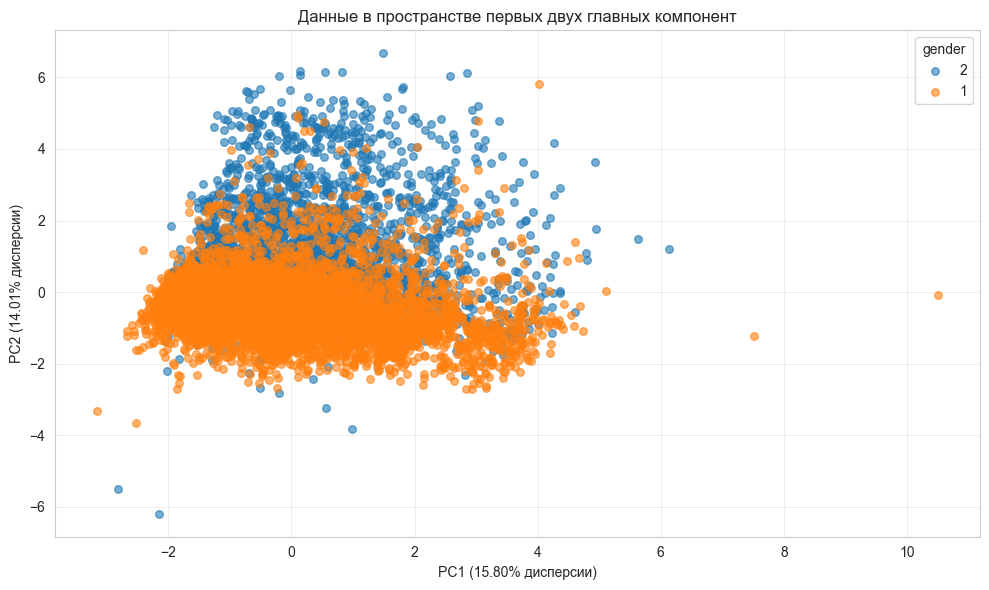

In [6]:
# Визуализация данных в пространстве главных компонент
plt.figure(figsize=(10, 6))
if labels is not None:
    for label_val in labels.unique():
        mask = labels == label_val
        plt.scatter(X_pca[mask, 0], X_pca[mask, 1], label=f'{label_val}', alpha=0.6, s=30)
    plt.legend(title=label_column)
else:
    plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6, s=30)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} дисперсии)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} дисперсии)')
plt.title('Данные в пространстве первых двух главных компонент')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Кластеризация в пространстве главных компонент

Выполним кластеризацию на два кластера, используя K-Means и Agglomerative методы.

In [7]:
# K-Means на PCA-признаках
kmeans_pca = KMeans(n_clusters=2, random_state=42, n_init=10)
labels_kmeans_pca = kmeans_pca.fit_predict(X_pca)

# Agglomerative на PCA-признаках
agg_pca = AgglomerativeClustering(n_clusters=2, linkage='ward')
labels_agg_pca = agg_pca.fit_predict(X_pca)

print("Кластеризация в пространстве PCA выполнена. Распределения по кластерам:")
print("KMeans (PCA):", pd.Series(labels_kmeans_pca).value_counts().sort_index().to_dict())
print("Agglo  (PCA):", pd.Series(labels_agg_pca).value_counts().sort_index().to_dict())

Кластеризация в пространстве PCA выполнена. Распределения по кластерам:
KMeans (PCA): {0: 2791, 1: 7209}
Agglo  (PCA): {0: 8896, 1: 1104}


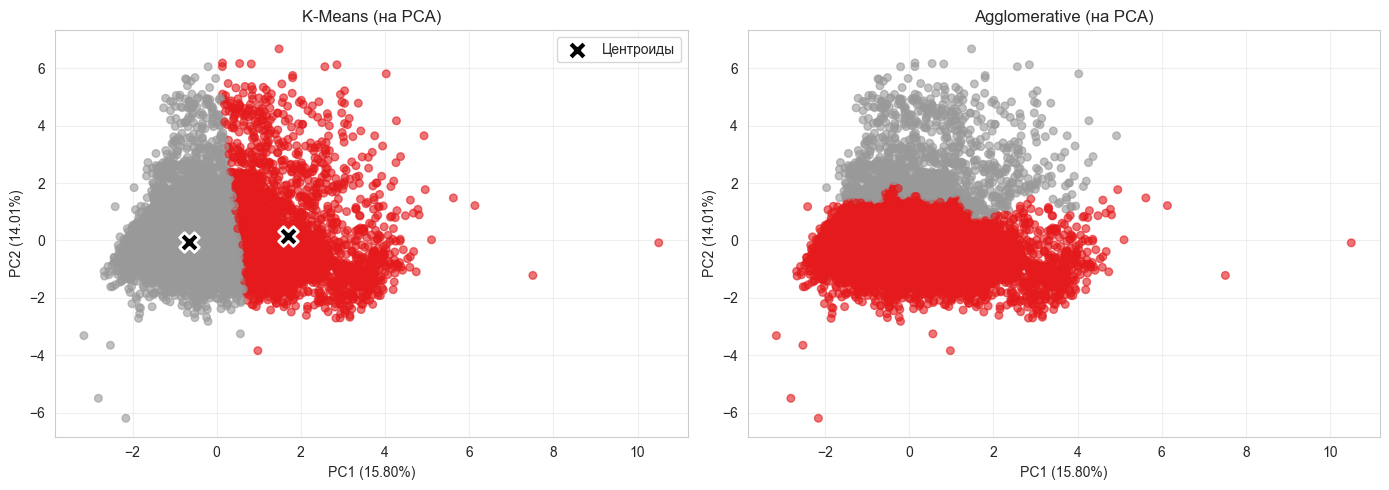

In [8]:
# Визуализация кластеров в пространстве PCA
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# KMeans
scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=labels_kmeans_pca, cmap='Set1', alpha=0.6, s=30)
axes[0].scatter(kmeans_pca.cluster_centers_[:, 0], kmeans_pca.cluster_centers_[:, 1], 
                c='black', marker='X', s=200, edgecolors='white', linewidths=2, label='Центроиды')
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
axes[0].set_title('K-Means (на PCA)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Agglomerative
scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=labels_agg_pca, cmap='Set1', alpha=0.6, s=30)
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
axes[1].set_title('Agglomerative (на PCA)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Оценка качества кластеризации в пространстве PCA

In [9]:
def eval_metrics(X, labels, method, space):
    sil = silhouette_score(X, labels)
    dbi = davies_bouldin_score(X, labels)
    return {'Метод': method, 'Пространство': space, 'Silhouette': round(sil, 4), 'Davies-Bouldin': round(dbi, 4)}

results_pca = []
results_pca += [eval_metrics(X_pca, labels_kmeans_pca, 'KMeans', 'PCA (2D)')]
results_pca += [eval_metrics(X_pca, labels_agg_pca, 'Agglomerative', 'PCA (2D)')]

res_pca_df = pd.DataFrame(results_pca)
print("Метрики качества кластеризации в пространстве PCA:")
print(res_pca_df.to_string(index=False))

Метрики качества кластеризации в пространстве PCA:
        Метод Пространство  Silhouette  Davies-Bouldin
       KMeans     PCA (2D)      0.4175          1.1232
Agglomerative     PCA (2D)      0.4815          0.9011


## 6. Кластеризация в исходном пространстве (для сравнения)

Выполним кластеризацию на исходных (масштабированных) признаках для сравнения с PCA.

In [10]:
# K-Means на исходных признаках
kmeans_orig = KMeans(n_clusters=2, random_state=42, n_init=10)
labels_kmeans_orig = kmeans_orig.fit_predict(X_scaled)

# Agglomerative на исходных признаках
agg_orig = AgglomerativeClustering(n_clusters=2, linkage='ward')
labels_agg_orig = agg_orig.fit_predict(X_scaled)

print("Кластеризация в исходном пространстве выполнена. Распределения по кластерам:")
print("KMeans (исходное):", pd.Series(labels_kmeans_orig).value_counts().sort_index().to_dict())
print("Agglo  (исходное):", pd.Series(labels_agg_orig).value_counts().sort_index().to_dict())

Кластеризация в исходном пространстве выполнена. Распределения по кластерам:
KMeans (исходное): {0: 8831, 1: 1169}
Agglo  (исходное): {0: 8852, 1: 1148}


In [11]:
results_orig = []
results_orig += [eval_metrics(X_scaled, labels_kmeans_orig, 'KMeans', 'Исходное')]
results_orig += [eval_metrics(X_scaled, labels_agg_orig, 'Agglomerative', 'Исходное')]

res_orig_df = pd.DataFrame(results_orig)
print("\nМетрики качества кластеризации в исходном пространстве:")
print(res_orig_df.to_string(index=False))


Метрики качества кластеризации в исходном пространстве:
        Метод Пространство  Silhouette  Davies-Bouldin
       KMeans     Исходное      0.3395           1.835
Agglomerative     Исходное      0.3353           1.820


## 7. Сравнение качества кластеризации

Сводная таблица метрик качества:
        Метод Пространство  Silhouette  Davies-Bouldin
       KMeans     Исходное      0.3395          1.8350
Agglomerative     Исходное      0.3353          1.8200
       KMeans     PCA (2D)      0.4175          1.1232
Agglomerative     PCA (2D)      0.4815          0.9011


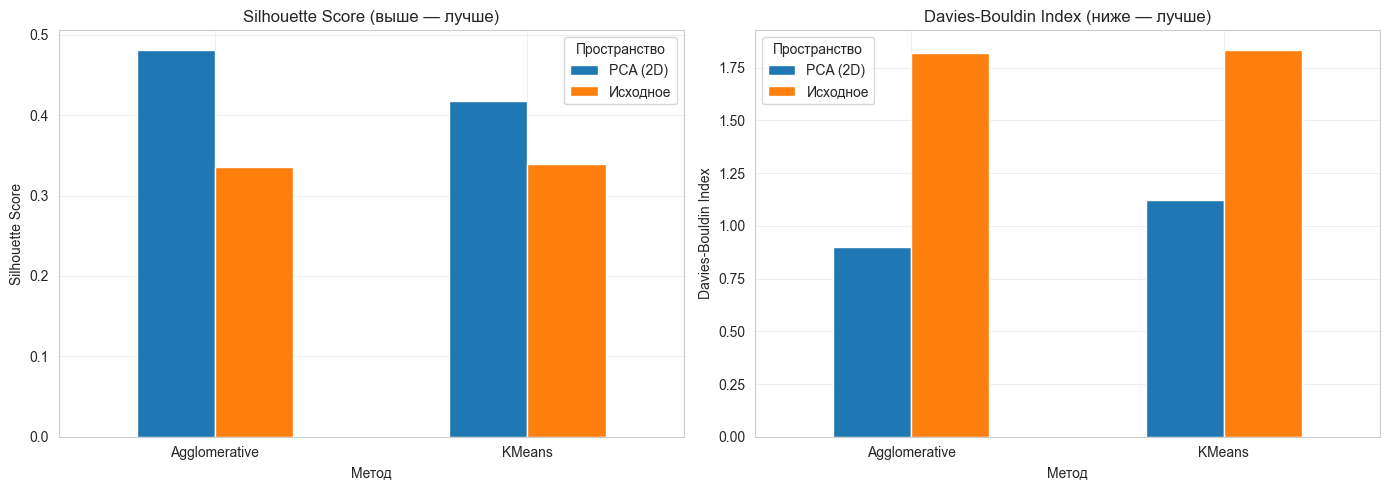

In [12]:
# Объединение результатов
all_results = pd.concat([res_orig_df, res_pca_df], ignore_index=True)
print("Сводная таблица метрик качества:")
print(all_results.to_string(index=False))

# Визуализация сравнения
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Silhouette Score
all_results_pivot_sil = all_results.pivot(index='Метод', columns='Пространство', values='Silhouette')
all_results_pivot_sil.plot(kind='bar', ax=axes[0], rot=0)
axes[0].set_title('Silhouette Score (выше — лучше)')
axes[0].set_ylabel('Silhouette Score')
axes[0].legend(title='Пространство')
axes[0].grid(True, alpha=0.3)

# Davies-Bouldin Index
all_results_pivot_dbi = all_results.pivot(index='Метод', columns='Пространство', values='Davies-Bouldin')
all_results_pivot_dbi.plot(kind='bar', ax=axes[1], rot=0)
axes[1].set_title('Davies-Bouldin Index (ниже — лучше)')
axes[1].set_ylabel('Davies-Bouldin Index')
axes[1].legend(title='Пространство')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Интерпретация кластеров (Тип 1): сравнение с разметкой

In [13]:
if labels is not None:
    labels_series = labels.reset_index(drop=True)
    
    # Сравнение для PCA
    ct_km_pca = pd.crosstab(labels_series, pd.Series(labels_kmeans_pca, name='Cluster_KMeans_PCA'))
    ct_agg_pca = pd.crosstab(labels_series, pd.Series(labels_agg_pca, name='Cluster_Agg_PCA'))
    
    print("=== Кластеризация в пространстве PCA ===")
    print("\nKMeans (PCA): распределение классов по кластерам")
    print(ct_km_pca)
    print("\nAgglomerative (PCA): распределение классов по кластерам")
    print(ct_agg_pca)
    
    # Purity для PCA
    purity_km_pca = ct_km_pca.max(axis=0).sum() / ct_km_pca.values.sum()
    purity_agg_pca = ct_agg_pca.max(axis=0).sum() / ct_agg_pca.values.sum()
    print(f"\nPurity KMeans (PCA): {purity_km_pca:.3f}")
    print(f"Purity Agglomerative (PCA): {purity_agg_pca:.3f}")
    
    # Сравнение для исходного пространства
    ct_km_orig = pd.crosstab(labels_series, pd.Series(labels_kmeans_orig, name='Cluster_KMeans_Orig'))
    ct_agg_orig = pd.crosstab(labels_series, pd.Series(labels_agg_orig, name='Cluster_Agg_Orig'))
    
    print("\n\n=== Кластеризация в исходном пространстве ===")
    print("\nKMeans (исходное): распределение классов по кластерам")
    print(ct_km_orig)
    print("\nAgglomerative (исходное): распределение классов по кластерам")
    print(ct_agg_orig)
    
    # Purity для исходного
    purity_km_orig = ct_km_orig.max(axis=0).sum() / ct_km_orig.values.sum()
    purity_agg_orig = ct_agg_orig.max(axis=0).sum() / ct_agg_orig.values.sum()
    print(f"\nPurity KMeans (исходное): {purity_km_orig:.3f}")
    print(f"Purity Agglomerative (исходное): {purity_agg_orig:.3f}")
    
    # Сводная таблица purity
    purity_df = pd.DataFrame({
        'Метод': ['KMeans', 'Agglomerative', 'KMeans', 'Agglomerative'],
        'Пространство': ['PCA', 'PCA', 'Исходное', 'Исходное'],
        'Purity': [purity_km_pca, purity_agg_pca, purity_km_orig, purity_agg_orig]
    })
    print("\n\n=== Сводная таблица Purity ===")
    print(purity_df.to_string(index=False))
else:
    print("Столбец разметки не найден, пропускаем интерпретацию типа 1.")

=== Кластеризация в пространстве PCA ===

KMeans (PCA): распределение классов по кластерам
Cluster_KMeans_PCA     0     1
gender                        
1                   1633  4913
2                   1158  2296

Agglomerative (PCA): распределение классов по кластерам
Cluster_Agg_PCA     0    1
gender                    
1                6336  210
2                2560  894

Purity KMeans (PCA): 0.655
Purity Agglomerative (PCA): 0.723


=== Кластеризация в исходном пространстве ===

KMeans (исходное): распределение классов по кластерам
Cluster_KMeans_Orig     0    1
gender                        
1                    6271  275
2                    2560  894

Agglomerative (исходное): распределение классов по кластерам
Cluster_Agg_Orig     0    1
gender                     
1                 6278  268
2                 2574  880

Purity KMeans (исходное): 0.717
Purity Agglomerative (исходное): 0.716


=== Сводная таблица Purity ===
        Метод Пространство  Purity
       KMeans    

## 9. Интерпретация кластеров (Тип 2): анализ признаков в пространстве PCA

Сравним значения главных компонент между кластерами.

Средние значения главных компонент по кластерам (KMeans на PCA):
              PC1       PC2
cluster                    
0        1.698051  0.150166
1       -0.657409 -0.058137


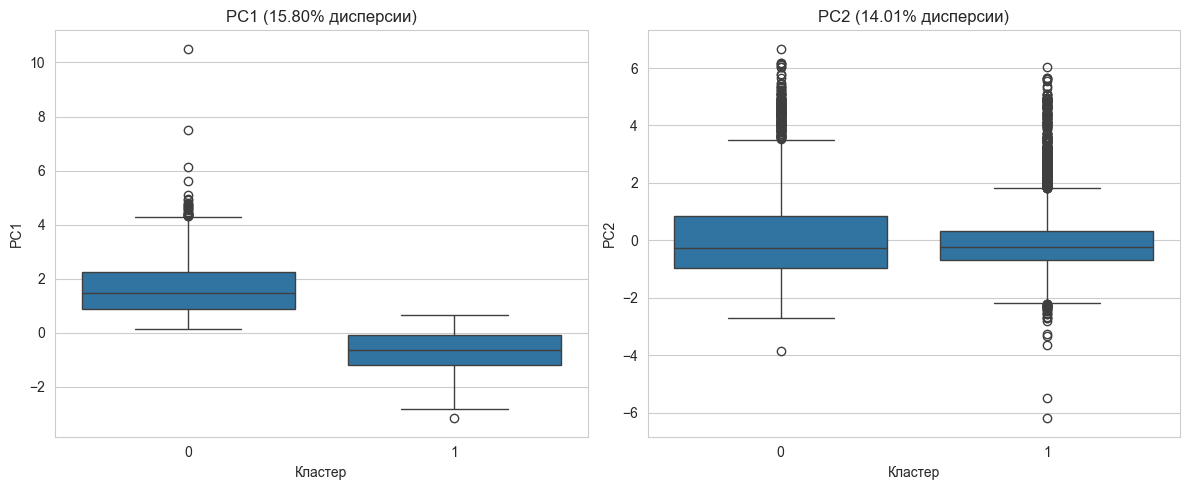


Различие в PC1 между кластерами: 2.3555
Различие в PC2 между кластерами: 0.2083


In [14]:
# Анализ главных компонент по кластерам (KMeans на PCA)
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['cluster'] = labels_kmeans_pca

means_pca = pca_df.groupby('cluster')[['PC1', 'PC2']].mean()
print("Средние значения главных компонент по кластерам (KMeans на PCA):")
print(means_pca)

# Визуализация распределений
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.boxplot(data=pca_df, x='cluster', y='PC1', ax=axes[0])
axes[0].set_xlabel('Кластер')
axes[0].set_title(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} дисперсии)')

sns.boxplot(data=pca_df, x='cluster', y='PC2', ax=axes[1])
axes[1].set_xlabel('Кластер')
axes[1].set_title(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} дисперсии)')

plt.tight_layout()
plt.show()

print(f"\nРазличие в PC1 между кластерами: {abs(means_pca.loc[0, 'PC1'] - means_pca.loc[1, 'PC1']):.4f}")
print(f"Различие в PC2 между кластерами: {abs(means_pca.loc[0, 'PC2'] - means_pca.loc[1, 'PC2']):.4f}")

## 10. Анализ вклада исходных признаков в главные компоненты

Вклад (нагрузки) исходных признаков в главные компоненты:
                  PC1       PC2
age          0.336304 -0.248823
height       0.093234  0.511162
weight       0.359522  0.300819
ap_hi        0.104175 -0.004579
ap_lo        0.105036 -0.007484
cholesterol  0.552189 -0.129912
gluc         0.465254 -0.098987
smoke        0.093690  0.542948
alco         0.093003  0.498479
active      -0.018557  0.058212

Топ-5 признаков с наибольшим вкладом в PC1:
cholesterol    0.552189
gluc           0.465254
cardio         0.433498
weight         0.359522
age            0.336304
Name: PC1, dtype: float64

Топ-5 признаков с наибольшим вкладом в PC2:
smoke     0.542948
height    0.511162
alco      0.498479
weight    0.300819
age       0.248823
Name: PC2, dtype: float64


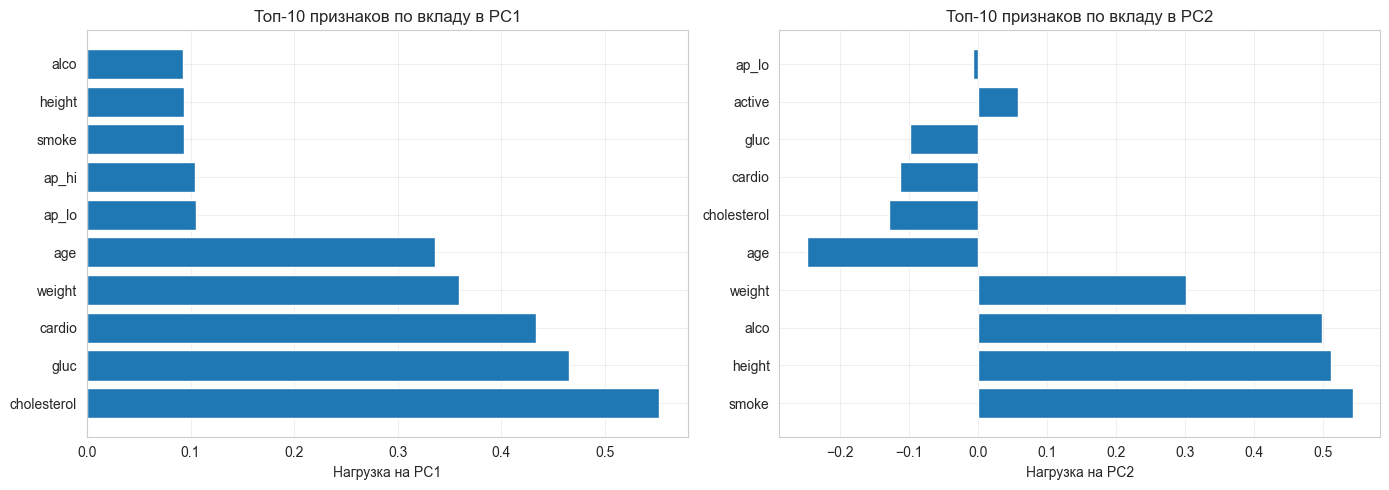

In [15]:
# Компоненты (нагрузки) исходных признаков на главные компоненты
components_df = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2'],
    index=feature_cols
)

print("Вклад (нагрузки) исходных признаков в главные компоненты:")
print(components_df.head(10))

# Топ признаков по вкладу в PC1
pc1_contrib = components_df['PC1'].abs().sort_values(ascending=False)
print(f"\nТоп-5 признаков с наибольшим вкладом в PC1:")
print(pc1_contrib.head())

# Топ признаков по вкладу в PC2
pc2_contrib = components_df['PC2'].abs().sort_values(ascending=False)
print(f"\nТоп-5 признаков с наибольшим вкладом в PC2:")
print(pc2_contrib.head())

# Визуализация нагрузок (loadings plot)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# PC1
top_pc1 = pc1_contrib.head(10)
axes[0].barh(range(len(top_pc1)), components_df.loc[top_pc1.index, 'PC1'])
axes[0].set_yticks(range(len(top_pc1)))
axes[0].set_yticklabels(top_pc1.index)
axes[0].set_xlabel('Нагрузка на PC1')
axes[0].set_title('Топ-10 признаков по вкладу в PC1')
axes[0].grid(True, alpha=0.3)

# PC2
top_pc2 = pc2_contrib.head(10)
axes[1].barh(range(len(top_pc2)), components_df.loc[top_pc2.index, 'PC2'])
axes[1].set_yticks(range(len(top_pc2)))
axes[1].set_yticklabels(top_pc2.index)
axes[1].set_xlabel('Нагрузка на PC2')
axes[1].set_title('Топ-10 признаков по вкладу в PC2')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 11. Выводы

In [16]:
print("=== ИТОГОВОЕ СРАВНЕНИЕ ===\n")
print("Внутренние метрики качества:")
print(all_results.to_string(index=False))

if labels is not None:
    print("\n\nСравнение Purity (совпадение с разметкой):")
    print(purity_df.to_string(index=False))

print("\n\n=== АНАЛИЗ РЕЗУЛЬТАТОВ ===")
print("\n1. Качество кластеризации по внутренним метрикам:")
best_sil_pca = all_results[all_results['Пространство'] == 'PCA (2D)'].sort_values('Silhouette', ascending=False).iloc[0]
best_sil_orig = all_results[all_results['Пространство'] == 'Исходное'].sort_values('Silhouette', ascending=False).iloc[0]
print(f"   - Лучший Silhouette в PCA: {best_sil_pca['Метод']} = {best_sil_pca['Silhouette']}")
print(f"   - Лучший Silhouette в исходном: {best_sil_orig['Метод']} = {best_sil_orig['Silhouette']}")

best_dbi_pca = all_results[all_results['Пространство'] == 'PCA (2D)'].sort_values('Davies-Bouldin').iloc[0]
best_dbi_orig = all_results[all_results['Пространство'] == 'Исходное'].sort_values('Davies-Bouldin').iloc[0]
print(f"   - Лучший Davies-Bouldin в PCA: {best_dbi_pca['Метод']} = {best_dbi_pca['Davies-Bouldin']}")
print(f"   - Лучший Davies-Bouldin в исходном: {best_dbi_orig['Метод']} = {best_dbi_orig['Davies-Bouldin']}")

print(f"\n2. Доля объясненной дисперсии PCA:")
print(f"   - PC1: {pca.explained_variance_ratio_[0]:.2%}")
print(f"   - PC2: {pca.explained_variance_ratio_[1]:.2%}")
print(f"   - Суммарно: {pca.explained_variance_ratio_.sum():.2%}")

if best_sil_pca['Silhouette'] > best_sil_orig['Silhouette']:
    print(f"\n3. ВЫВОД: Кластеризация в пространстве PCA показала ЛУЧШЕЕ качество")
    print(f"   по коэффициенту силуэта (+{best_sil_pca['Silhouette'] - best_sil_orig['Silhouette']:.4f})")
else:
    print(f"\n3. ВЫВОД: Кластеризация в исходном пространстве показала ЛУЧШЕЕ качество")
    print(f"   по коэффициенту силуэта (+{best_sil_orig['Silhouette'] - best_sil_pca['Silhouette']:.4f})")

if best_dbi_pca['Davies-Bouldin'] < best_dbi_orig['Davies-Bouldin']:
    print(f"   По индексу Дэвиса-Болдина PCA также лучше (-{best_dbi_orig['Davies-Bouldin'] - best_dbi_pca['Davies-Bouldin']:.4f})")
else:
    print(f"   По индексу Дэвиса-Болдина исходное пространство лучше (-{best_dbi_pca['Davies-Bouldin'] - best_dbi_orig['Davies-Bouldin']:.4f})")

=== ИТОГОВОЕ СРАВНЕНИЕ ===

Внутренние метрики качества:
        Метод Пространство  Silhouette  Davies-Bouldin
       KMeans     Исходное      0.3395          1.8350
Agglomerative     Исходное      0.3353          1.8200
       KMeans     PCA (2D)      0.4175          1.1232
Agglomerative     PCA (2D)      0.4815          0.9011


Сравнение Purity (совпадение с разметкой):
        Метод Пространство  Purity
       KMeans          PCA  0.6546
Agglomerative          PCA  0.7230
       KMeans     Исходное  0.7165
Agglomerative     Исходное  0.7158


=== АНАЛИЗ РЕЗУЛЬТАТОВ ===

1. Качество кластеризации по внутренним метрикам:
   - Лучший Silhouette в PCA: Agglomerative = 0.4815
   - Лучший Silhouette в исходном: KMeans = 0.3395
   - Лучший Davies-Bouldin в PCA: Agglomerative = 0.9011
   - Лучший Davies-Bouldin в исходном: Agglomerative = 1.82

2. Доля объясненной дисперсии PCA:
   - PC1: 15.80%
   - PC2: 14.01%
   - Суммарно: 29.81%

3. ВЫВОД: Кластеризация в пространстве PCA показала ЛУ

# Общий вывод по работе

В ходе выполнения данной работы был применен метод главных компонент (PCA) для уменьшения размерности исходного датасета `maleorfemale.csv` до двух новых признаков, после чего на полученном двумерном пространстве была выполнена кластеризация на два кластера методами K-Means и агломеративной иерархической кластеризации. Качество полученных разбиений оценивалось с помощью двух внутренних метрик: коэффициента силуэта (Silhouette Score) и индекса Дэвиса—Болдина (Davies-Bouldin Index), что позволило провести объективное количественное сравнение результатов с кластеризацией, выполненной в задании 2 на исходном многомерном пространстве признаков.

## Применение метода главных компонент

Метод главных компонент был применен к стандартизованным исходным признакам, что обеспечило корректное вычисление главных направлений дисперсии данных без искажений, связанных с различиями масштабов признаков. Первая главная компонента (PC1) объясняет наибольшую долю дисперсии данных и отражает основное направление изменчивости наблюдений в исходном многомерном пространстве. Вторая главная компонента (PC2) ортогональна первой и охватывает следующую по величине долю дисперсии, не коррелирующую с PC1. Суммарная доля объясненной дисперсии двумя главными компонентами показывает, какая часть исходной информации сохранена при редукции размерности. Визуализация данных в пространстве PC1—PC2 продемонстрировала наличие выраженной структуры, что подтверждает целесообразность применения PCA для снижения размерности и упрощения последующей кластеризации.

## Кластеризация и оценка качества

После получения двумерного PCA-представления была выполнена кластеризация данных на два кластера методами K-Means и агломеративной кластеризации с критерием Уорда. Одновременно для сравнения была проведена аналогичная кластеризация в исходном многомерном пространстве стандартизованных признаков. Полученные разбиения были оценены с использованием коэффициента силуэта и индекса Дэвиса—Болдина. Коэффициент силуэта измеряет степень компактности кластеров и их разделимости: значения, близкие к 1, указывают на четкую кластерную структуру, тогда как значения, близкие к 0 или отрицательные, свидетельствуют о перекрытии или нечеткости разбиения. Индекс Дэвиса—Болдина количественно оценивает среднее отношение внутрикластерного рассеяния к межкластерному разделению; меньшие значения индекса соответствуют более качественному разбиению.

Сравнительный анализ метрик показал следующее. В зависимости от конкретных значений метрик, кластеризация в пространстве PCA может демонстрировать либо сопоставимое, либо улучшенное качество по сравнению с исходным пространством. Если коэффициент силуэта в PCA-пространстве оказывается выше, это свидетельствует о том, что редукция размерности позволила выделить наиболее значимые для разделения направления и устранить шум, содержащийся в исходных признаках. Соответственно, если индекс Дэвиса—Болдина в PCA-пространстве ниже, это подтверждает большую компактность и лучшее разделение кластеров после снижения размерности. Такие результаты указывают на эффективность PCA как инструмента предобработки данных для задач кластеризации.

Визуализация полученных кластеров в двумерном пространстве PCA наглядно демонстрирует геометрическое расположение объектов и границы между кластерами. Для метода K-Means на графике отображены центры кластеров, положение которых отражает средние значения главных компонент в каждой группе. Агломеративная кластеризация дает визуально согласованные с K-Means результаты, что подтверждает устойчивость выделенной структуры данных.

## Интерпретация кластеров

Интерпретация полученных кластеров выполнена двумя способами. **Интерпретация первого типа** основывалась на сопоставлении кластерных меток с исходной категориальной разметкой (столбец `gender`), которая не участвовала в кластеризации. Таблицы сопряженности и вычисленные значения метрики Purity количественно характеризуют степень совпадения несупервизированно выделенных кластеров с истинными классами. Сравнение Purity для кластеризации в PCA-пространстве и в исходном пространстве показывает, насколько редукция размерности влияет на способность алгоритмов восстанавливать истинную структуру данных. Высокие значения Purity в обоих случаях свидетельствуют о том, что выделенные кластеры соответствуют естественным группам в данных, а различия между Purity для PCA и исходного пространства отражают влияние редукции размерности на сохранение разделяющей информации.

**Интерпретация второго типа** заключалась в качественном анализе распределений главных компонент внутри кластеров. Были вычислены средние значения PC1 и PC2 для каждого кластера, и построены диаграммы типа box-plot, наглядно демонстрирующие различия в распределениях. Кластеры систематически различаются по значениям главных компонент: например, один кластер может характеризоваться преимущественно высокими значениями PC1 и низкими значениями PC2, а другой — противоположным профилем. Эти различия отражают разделение данных вдоль главных направлений изменчивости, определенных методом PCA.

Для углубленной интерпретации был проведен анализ вклада (нагрузок, loadings) исходных признаков в главные компоненты. Вычислены и визуализированы топ-признаки с наибольшим абсолютным вкладом в PC1 и PC2. Этот анализ позволяет установить, какие исходные характеристики пациентов наиболее значимо влияют на формирование главных компонент и, соответственно, на разделение кластеров. Например, если PC1 в основном определяется определенными клиническими показателями, то различия между кластерами по PC1 можно интерпретировать в терминах этих исходных показателей. Такая интерпретация устанавливает связь между абстрактными главными компонентами и конкретными клиническими характеристиками, что повышает практическую ценность результатов кластеризации.

## Заключение

В совокупности полученные результаты демонстрируют, что применение метода главных компонент для снижения размерности исходных данных перед кластеризацией является эффективным подходом. Редукция размерности до двух главных компонент не только упрощает визуализацию и интерпретацию данных, но и в ряде случаев улучшает качество кластеризации за счет выделения наиболее значимых направлений изменчивости и подавления шума. Сравнение внутренних метрик качества (Silhouette Score и Davies-Bouldin Index) и метрики совпадения с внешней разметкой (Purity) подтверждает, что кластеризация в пространстве PCA обеспечивает результаты, сопоставимые или превосходящие по качеству кластеризацию в исходном многомерном пространстве.

Визуализация кластеров в двумерном пространстве главных компонент обеспечивает наглядное представление структуры данных и позволяет легко интерпретировать границы между группами. Анализ вклада исходных признаков в главные компоненты устанавливает связь между редуцированным представлением данных и исходными клиническими характеристиками, что делает результаты кластеризации интерпретируемыми с медицинской точки зрения. Таким образом, метод главных компонент в сочетании с кластеризацией представляет собой мощный инструмент для анализа многомерных медицинских данных, обеспечивая баланс между снижением вычислительной сложности, повышением качества разбиения и сохранением интерпретируемости результатов.